**Machine Learning Development life cycle**  
1. Task  
2. Data Preparation  
3. Modelling
4. Error Measurement
5. Training and Optimization
6. Performance Measurement
7. Validating and Testing
8. Corrective Measures

Using Python 3.10.13

In [59]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds 

**Data Preparation**

![Dataset split](Dataset_Split.png "Dataset split")  
The split of this dataset is only "Train", so we can't have "Test"

In [60]:
dataset, dataset_info = tfds.load("malaria", with_info = True, shuffle_files=True, as_supervised=True, split=["train"])

In [61]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [62]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/Users/cheesemac/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blo

In [63]:
for data in dataset[0].take(5):
    print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [64]:
print(len(dataset[0]))

27558


Now we define a `splits()` function to split our dataset into train, validation and test sets with given ratios, using `take()` and `skip()`

In [65]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))

    val_dataset = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))
    val_dataset = val_dataset.take(int(DATASET_SIZE*VAL_RATIO))

    test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO + VAL_RATIO)))

    return train_dataset, val_dataset, test_dataset

Looking at the picture about the splits of this dataset, we should note that this dataset is of type `list`, in order to access the data, we have to go to index `0`, so `dataset[0]`

In [66]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 1 - (TRAIN_RATIO + VAL_RATIO)

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2755
2756


In [67]:
print(list(train_dataset.take(5).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

In [70]:
for data in train_dataset.take(16):
    print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

**Dataset Visualization**

In [91]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/Users/cheesemac/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blo

Looking at `"label"`, we can see that it is of `ClassLabel()` feature, with `num_classes = 2` meaning that it contains 2 classes. Labels are stored as integers in the dataset. When you retrieve the labels, `ClassLabel.int2str()` and `ClassLabel.str2int()` carries out the conversion from integer value to label name, and vice versa.  

There is also `Value()` feature.

*Referenced from:* https://huggingface.co/docs/datasets/about_dataset_features

Using `plt.subplot`

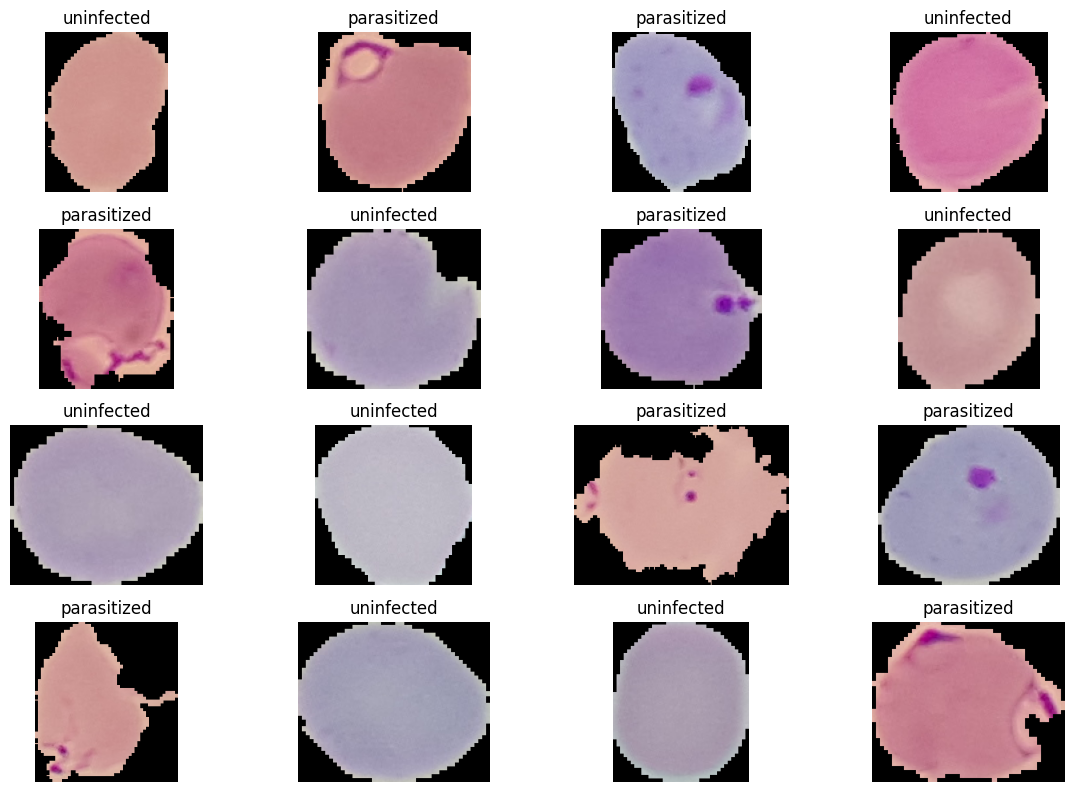

In [92]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(train_dataset.take(16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(dataset_info.features["label"].int2str(label))
    plt.axis("off")

plt.tight_layout(pad=1)

**Data Processing**

When do we use stadardization, and when normalization?  
* We use standardization when the data in our dataset lie mainly around a mean with standard deviation.
* We use normalization when the data in our dataset are mainly different and is distributed fairly randomly within a range (min, max)

That explains why normalization is a better suit for this dataset, since the values lie between 0 and 255 and are faily random. In this case, our normalization formula is going to be `(x - x_min)/(x_max - x_min) = x / 255`

First, we need to resize our images to have an uniform size

We will use `map()` attribute to apply a resizing function to our dataset. But since this attribute only return our image and not our label, which is also needed to assign to our dataset, we will first define a resizing function

In [96]:
def resize_normalize(img, label):
    IMG_SIZE = 224
    return tf.image.resize(img, [IMG_SIZE, IMG_SIZE]) / 255, label

In [97]:
train_dataset = train_dataset.map(resize_normalize)

In [98]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


The data type of `resize_normalize(img, label)[0]` is kind of like a list or an array, that's why we can broadcast like `tf.image.resize(img, [IMG_SIZE, IMG_SIZE]) / 255` in the function `resize_normalize`

In [108]:
for img, label in train_dataset.take(1):
    print(list(resize_normalize(img, label)[0]))

[<tf.Tensor: shape=(224, 3), dtype=float32, numpy=
array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
    

In [110]:
train_dataset = train_dataset.shuffle(buffer_size= 500, reshuffle_each_iteration=True).batch(200).prefetch(tf.data.AUTOTUNE)

**Convolutional Neural Network (CNN)**  
For better visualization: https://poloclub.github.io/cnn-explainer/  
Note for padding: When using padding, we have to ensure that the outer layers (especially the corners) still have impact on the data

Padding is especially useful when the actual image is located somewhere in the outer layer. When padding, the cursor with given kernel size will go through the image more times.  

`output = (input + 2 * Padding - Kernel)/Stride + 1`